In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import liveModelling
from liveModelling import simulate

from matplotlib import cm
import matplotlib

#normalize item number values to colormap
norm = matplotlib.colors.Normalize(vmin=-30, vmax=30)

#colormap possible values = viridis, jet, spectral
rgba_color = cm.plasma(norm(400),bytes=True)

In [2]:


parameter_values = pd.read_csv('../median_networks_for_clusters.csv')

name = '1'
params=parameter_values[parameter_values['cluster']==name].iloc[0, 1:25]


simulation = pd.read_csv(f'../output/{name}.csv', sep = ';')

simulation['time'] = simulation['Time']

In [3]:
col_list = ['#ed392b', '#feb441', '#4090c5']
col_max = ['#af1117', '#ea6e13', '#0f59a3']
gene_list = ['tbxta', 'tbx16', 'tbx6']
emb_cmap = ['Reds', 'YlOrBr', 'Blues']

In [4]:
ICs = simulation[simulation['Time'] == 1]

track_list = ICs[
    (ICs['X'] < 100) # &
    # (ICs['g3'] < 0.1)
    # (ICs['X'] > 60 ) &
    # (ICs['X'] < 80 ) &
    # (ICs['Y'] > -20 ) &
    # (ICs['Y'] < 20 )
    ]['TrackID']



In [5]:
import seaborn as sns
gene_names = ['tbxta', 'tbx16', 'tbx6']

palette = {"anterior": "c", "posterior": "m"}

In [6]:
sig = []
g0 = []
t_evals = []

# colours = ['red', 'blue']

params = np.array(params)




# fig, ax = plt.subplots(1, 3, figsize = (10, 3))

sig = []
g0 = []
t_evals = []
x_shift = []
total_movement = []

pos = []


# for track in np.random.choice(track_list, 10):
for track in track_list:
    data = simulation[simulation['TrackID']==track].reset_index(drop = True)
    B1 = np.array(data['Wnt'])
    B2 = np.array(data['FGF'])
    sig.append([B1, B2])
    g0.append(np.array(data.loc[0, ['g1', 'g2', 'g3']]))
    t_eval = []
    for index in data.index[:-1]:
        count_timesteps_between = data.Time[index+1] - data.Time[index] # number of time steps between observations, sometimes an observation at a specific time is missing
        # t_eval.append(int(count_timesteps_between)*10)
        t_eval.append(
            np.array(np.linspace(
                data.Time_nPSM[index], data.Time_nPSM[index+1], 10)
        ))

    t_evals.append(t_eval)
    mvmt = data.loc[data.shape[0]-1, 'X'] - data.loc[0, 'X']
    # print(mvmt)
    x_shift.append(mvmt)
    pos.append(data.loc[:, ['X', 'Y', 'Z']])


sims = []

for i in range(len(sig)):
    B1 = sig[i][0]
    B2 = sig[i][1]
    t_eval = t_evals[i]
    s0 = g0[i]
    simulated_expression = simulate.simulate_single_track(B1, B2, np.array(t_eval), s0, params)
    sims.append(simulated_expression)


In [7]:
thresh = 0.1

0.6842105263157895
0.18994413407821228


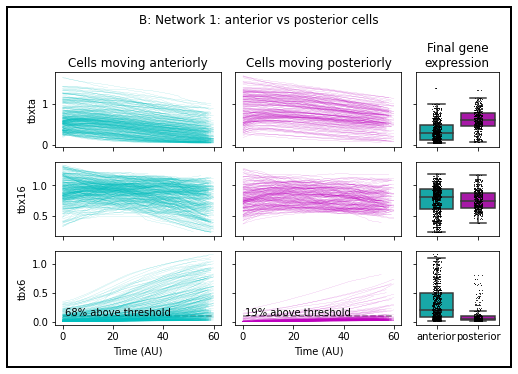

In [8]:

def plot_trajectories(sims, x_shift, fig_w = 10, fig_h = 6):

    fig, ax = plt.subplots(3,3,
                           figsize = (fig_w, fig_h),
                           gridspec_kw={'width_ratios': [1, 1, 0.5]},
                           sharey = 'row',
                           tight_layout = True,
                           sharex = 'col')

    final_g1_ant = []
    final_g1_post = []
    final_g2_ant = []
    final_g2_post = []
    final_g3_ant = []
    final_g3_post = []

    # graph threshold line first.
    ax[2, 0].hlines(thresh, xmin = 0, xmax = 60, color = 'grey', linestyle = 'dashed')
    ax[2, 1].hlines(thresh, xmin = 0, xmax = 60, color = 'grey', linestyle = 'dashed')

    for idx, sim in enumerate(sims):
        for i in range(3):
            if x_shift[idx] > 0:
                # anterior
                ax[i, 0].plot(sim[:, i],
                              linewidth = 0.1,
                              color = 'c')
                final_g1_ant.append(sim[-1, 0])
                final_g2_ant.append(sim[-1, 1])
                final_g3_ant.append(sim[-1, 2])
            else:
                ax[i, 1].plot(
                    sim[:, i],
                    linewidth = 0.1,
                    color = 'm'
                    )
                final_g1_post.append(sim[-1, 0])
                final_g2_post.append(sim[-1, 1])
                final_g3_post.append(sim[-1, 2])

    prop_ant = np.count_nonzero(np.array(final_g3_ant) > thresh) / len(final_g3_ant)
    print(prop_ant)
    prop_post = np.count_nonzero(np.array(final_g3_post) > thresh) / len(final_g3_post)
    print(prop_post)

    # Creating DataFrames for each group
    df1 = pd.DataFrame({'Group': 'G1', 'Condition': ['anterior'] * len(final_g1_ant) + ['posterior'] * len(final_g1_post),
                        'Value': final_g1_ant + final_g1_post})

    df2 = pd.DataFrame({'Group': 'G2', 'Condition': ['anterior'] * len(final_g2_ant) + ['posterior'] * len(final_g2_post),
                        'Value': final_g2_ant + final_g2_post})

    df3 = pd.DataFrame({'Group': 'G3', 'Condition': ['anterior'] * len(final_g3_ant) + ['posterior'] * len(final_g3_post),
                        'Value': final_g3_ant + final_g3_post})

    # Combine all into one DataFrame
    df = pd.concat([df1, df2, df3])


    for i, group in enumerate(['G1', 'G2', 'G3']):
        sns.boxplot(data=df[df['Group'] == group],
                       x='Condition', y='Value',
                       ax=ax[i, 2],
                       # inner=None,
                       # fill = False,
                    palette=palette,
                    fliersize=0,
                    #    cut = True,
                    #    alpha=0.1
                       )
        sns.stripplot(data=df[df['Group'] == group],
                      x='Condition', y='Value',
                      ax=ax[i, 2], color='black',
                      jitter=True, size=1)

        ax[i, 0].set_ylabel(gene_names[i])
        # Remove x and y axis labels
        ax[i, 2].set_xlabel("")  # Removes "Condition" label
        ax[i, 2].set_ylabel("")  # Removes "Value" label

    ax[0, 0].set_title('Cells moving anteriorly')
    ax[0, 1].set_title('Cells moving posteriorly')
    ax[0, 2].set_title('Final gene\nexpression')

    ax[2, 0].set_xlabel('Time (AU)')
    ax[2, 1].set_xlabel('Time (AU)')



    # Add a border using a rectangle
    ant_text = f'{round(prop_ant*100)}% above threshold'
    ax[2, 0].annotate(xy = (1, thresh*1.1), text = ant_text)
    post_text = f'{round(prop_post*100)}% above threshold'
    ax[2, 1].annotate(xy = (1, thresh*1.1), text = post_text)

    rect = plt.Rectangle(
        (0, 0), 1, 1,  # Position and size (normalized coordinates)
        transform=fig.transFigure,
        color="black",
        linewidth=2,
        fill=False
    )

    fig.patches.append(rect)

    return(fig)


fig = plot_trajectories(sims, x_shift, fig_w = 7, fig_h = 5)

fig.suptitle('B: Network 1: anterior vs posterior cells')

plt.savefig('../graphics/MAP_network/net1_anterior_vs_posterior_WT_cells.png',
            dpi = 600,
            facecolor = 'white')

I've quantified the rate of differentiation using 1. the total increase in tbx6 over the simulation, and 2. the time it takes until tbx6 crosses a threshold (0.05 expression).  There is no strong correlation - if anything differentiation is slower in cells moving forwards but it might not be statistically signficicant. 

Text(0.5, 1.0, 'Final tbx6 expression')

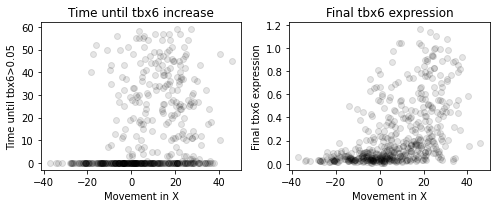

In [9]:
tbx6_increase = []

for i in sims:
    where_tbx6_increases = np.where(i[:, 2] > 0.1)[0]
    if len(where_tbx6_increases) > 1:
        tbx6_increase.append(where_tbx6_increases[0])
    else:
        tbx6_increase.append(0)

final_tbx6 = []

for i in sims:
    final_tbx6.append(i[-1, 2])


fig, ax = plt.subplots(1, 2, figsize = (7, 3), tight_layout = True)

ax[0].scatter(x_shift, tbx6_increase, c = 'k', alpha = 0.1)
ax[0].set_xlabel('Movement in X')
ax[0].set_ylabel('Time until tbx6>0.05')

ax[0].set_title('Time until tbx6 increase')

ax[1].scatter(x_shift, final_tbx6, c = 'k', alpha = 0.1)
ax[1].set_xlabel('Movement in X')
ax[1].set_ylabel('Final tbx6 expression')

ax[1].set_title('Final tbx6 expression')

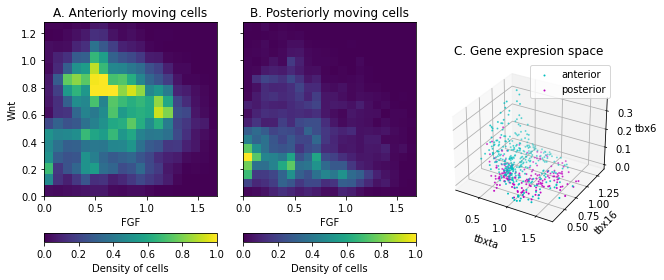

In [10]:
fig, ax = plt.subplots(1,3,
                       figsize = (9, 4),
                       sharex=True, sharey = True,
                       tight_layout = True)

ant_sig_1 = []
ant_sig_2 = []
post_sig_1 = []
post_sig_2 = []

for idx, s in enumerate(sig):
    if x_shift[idx] > 0:
        ant_sig_1.append(s[0])
        ant_sig_2.append(s[1])
    elif x_shift[idx] < -0:
        post_sig_1.append(s[0])
        post_sig_2.append(s[1])


ax[0].hist2d(
    np.concatenate(ant_sig_1).flatten(),
    np.concatenate(ant_sig_2).flatten(),
    bins = 20)



ax[1].hist2d(
    np.concatenate(post_sig_1).flatten(),
    np.concatenate(post_sig_2).flatten(),
    bins = 20)

ax[0].set_xlabel('FGF')
ax[1].set_xlabel('FGF')
ax[0].set_ylabel('Wnt')

ax[2].axis('off')

axs = fig.add_subplot(1, 3, 3, projection = '3d')

g0_ = np.array(g0)
ant_g0 = g0_[np.array(x_shift) > 0]
post_g0 = g0_[np.array(x_shift) < 0]
hist1 = axs.scatter3D(ant_g0[:, 0],
              ant_g0[:, 1],
              ant_g0[:, 2],
              c = 'c', s  = 1,
              label = 'anterior'

              )
hist2 = axs.scatter3D(post_g0[:, 0],
              post_g0[:, 1],
              post_g0[:, 2],
              c = 'm', s  = 1,
              label = 'posterior'
              )


cbar1 = fig.colorbar(hist1, ax=ax[0], orientation='horizontal')
cbar2 = fig.colorbar(hist2, ax=ax[1], orientation='horizontal')

cbar1.set_label("Density of cells")
cbar2.set_label("Density of cells")


axs.set_xlabel('tbxta')
axs.set_ylabel('tbx16')
axs.set_zlabel('tbx6')
axs.set_title('C. Gene expresion space')
axs.legend()


 #fig.suptitle('Signalling space differs for anterior and posteriorally moving cells')

ax[0].set_title('A. Anteriorly moving cells')
ax[1].set_title('B. Posteriorly moving cells')


plt.savefig('../graphics/MAP_network/gene_expr_space.png', dpi = 300, facecolor= 'white')

Finally, I wanted to confirm that this pattern wasn't due to those particular initial conditions being unusual. Accordingly, I took the rolling average of gene expression along the PSM, and took the gene expression at evenly spaced positions along that. 

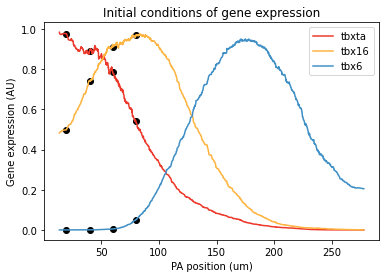

In [11]:
genes_groundtruth = []

from scipy.ndimage.filters import uniform_filter1d


sim_s = simulation[simulation['time'] == 1].reset_index(drop = True)

x = np.array(list(sim_s.sort_values("X")['X']))

ics = pd.DataFrame({'Wnt': [], 'FGF': [], })
ics['X'] = np.arange(20, 100, 20)

for idx, gene in enumerate(['g1', 'g2', 'g3']):
        yhat_1 = uniform_filter1d(sim_s.sort_values("X")[gene], size = 100, mode = 'nearest')
        genes_groundtruth.append(yhat_1)

        gene_ics = []
        for xpos in ics['X']:
            idx = (np.abs(x - xpos)).argmin()
            plt.scatter(x[idx], list(yhat_1)[idx], c = 'k')
            gene_ics.append(list(yhat_1)[idx])
        ics[gene] = gene_ics


plt.plot(x, genes_groundtruth[0],
         color = col_list[0],
         label = 'tbxta')
plt.plot(x, genes_groundtruth[1],
         color = col_list[1],
         label = 'tbx16'

         )
plt.plot(x, genes_groundtruth[2],
         color = col_list[2],
         label = 'tbx6')

plt.legend()

plt.title('Initial conditions of gene expression')

plt.xlabel('PA position (um)')
plt.ylabel('Gene expression (AU)')

plt.savefig('../graphics/MAP_network/Gene_Expr_ICs.png', dpi = 300)

When we run the simulations from those initial conditions, we get the same result. 

In [12]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def plot_3d(sims, x_shift):

    sims = np.array(sims)

    ant_sims = sims[np.array(x_shift) > 0]
    post_sims = sims[np.array(x_shift) < 0]

    fig = plt.figure(
        figsize = (3, 3),
        dpi = 600
        )
    lines_a = Line3DCollection(ant_sims, colors='c',
                            alpha=0.5, linewidths=0.1)
    lines_p = Line3DCollection(post_sims, colors='m',
                            alpha=0.5, linewidths=0.1)

    axs = fig.add_subplot(111, projection = '3d',
                            #sharex = axs, sharey = axs
                            )
    axs.add_collection(lines_a)
    axs.add_collection(lines_p)

    axs.set_xlim(0, 1.5)
    axs.set_ylim(0, 1.5)
    axs.set_zlim(0, 2)

    axs.set_xlabel('tbxta')
    axs.set_ylabel('tbx16')
    axs.set_zlabel('tbx6')


    # plt.savefig(f'../graphics/network_1/anterior_vs_posterior_Pos_{x}_3d.png', dpi = 600,
    #             facecolor = 'white')


In [13]:
import string

alphabet = list(string.ascii_uppercase)

0.39766081871345027
0.055865921787709494
0.47076023391812866
0.10614525139664804
0.6140350877192983
0.17318435754189945
0.956140350877193
0.9441340782122905


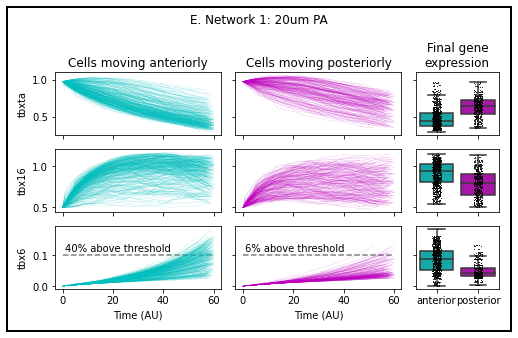

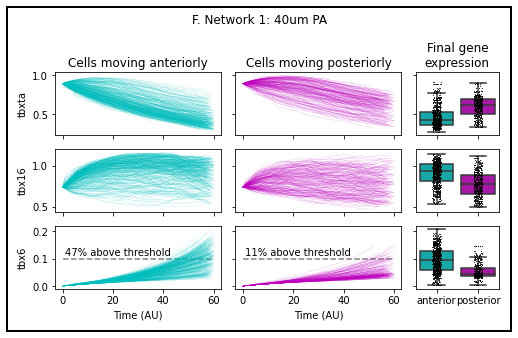

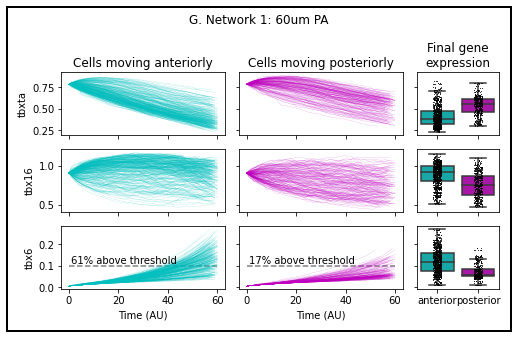

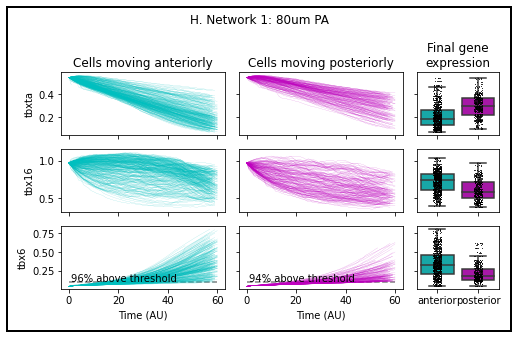

In [14]:
sig = []
g0 = []
t_evals = []

# colours = ['red', 'blue']

params = np.array(params)

ICs = simulation[simulation['Time'] == 1]

track_list = ICs[
    (ICs['X'] < 100) # &
    # (ICs['g3'] < 0.1)
    # (ICs['X'] > 60 ) &
    # (ICs['X'] < 80 ) &
    # (ICs['Y'] > -20 ) &
    # (ICs['Y'] < 20 )
    ]['TrackID']


def run_simulations(s0, name):
    sig = []
    g0 = []
    t_evals = []
    x_shift = []
    total_movement = []

    pos = []

    # for track in np.random.choice(track_list, 10):
    for track in track_list:
        data = simulation[simulation['TrackID']==track].reset_index(drop = True)
        B1 = np.array(data['Wnt'])
        B2 = np.array(data['FGF'])
        sig.append([B1, B2])
        g0.append(np.array(data.loc[0, ['g1', 'g2', 'g3']]))
        t_eval = []
        for index in data.index[:-1]:
            count_timesteps_between = data.Time[index+1] - data.Time[index] # number of time steps between observations, sometimes an observation at a specific time is missing
            # t_eval.append(int(count_timesteps_between)*10)
            t_eval.append(
                np.array(np.linspace(
                    data.Time_nPSM[index], data.Time_nPSM[index+1], 10)
            ))

        t_evals.append(t_eval)
        mvmt = data.loc[data.shape[0]-1, 'X'] - data.loc[0, 'X']
        # print(mvmt)
        x_shift.append(mvmt)
        pos.append(data.loc[:, ['X', 'Y', 'Z']])

    sims = []

    for i in range(len(sig)):
        B1 = sig[i][0]
        B2 = sig[i][1]
        t_eval = t_evals[i]
        simulated_expression = simulate.simulate_single_track(B1, B2, np.array(t_eval), s0, params)
        sims.append(simulated_expression)

    return(sims, x_shift)





for _, row in ics.iterrows():
    s0 = row[['g1', 'g2', 'g3']].values
    x = row['X']
    # print(s0)

    sims, x_shift = run_simulations(s0, str(x))

    fig = plot_trajectories(sims, x_shift, fig_w = 7, fig_h = 4.5)
    fig.suptitle(f'{alphabet[_+4]}. Network 1: {round(x)}um PA')

    plt.savefig(f'../graphics/MAP_network/net1_anterior_vs_posterior_Pos_{x}.png', dpi = 600,
                facecolor = 'white')



    # plot_3d(sims, x_shift)


0.5143953934740882
0.46641074856046066


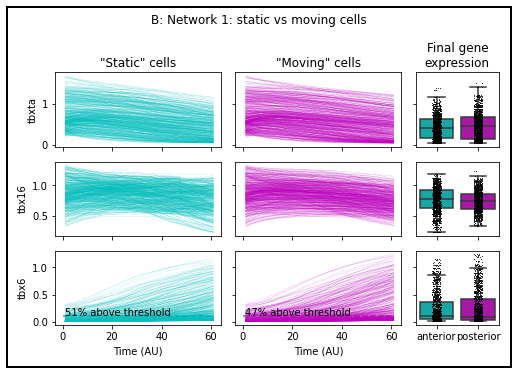

In [16]:

def plot_trajectories_static(sim, fig_w = 10, fig_h = 6):

    fig, ax = plt.subplots(3,3,
                           figsize = (fig_w, fig_h),
                           gridspec_kw={'width_ratios': [1, 1, 0.5]},
                           sharey = 'row',
                           tight_layout = True,
                           sharex = 'col')

    # graph threshold line first.
    ax[2, 0].hlines(thresh, xmin = 0, xmax = 60, color = 'grey', linestyle = 'dashed')
    ax[2, 1].hlines(thresh, xmin = 0, xmax = 60, color = 'grey', linestyle = 'dashed')


    final_g1_ant = []
    final_g1_post = []
    final_g2_ant = []
    final_g2_post = []
    final_g3_ant = []
    final_g3_post = []

    for track in track_list:
        sim_s = sim[sim['TrackID']==track]
        for i in range(3):
            # anterior
            ax[i, 0].plot(sim_s['Time'], sim_s[f'g{i+1}_sim'],
                            linewidth = 0.1,
                            color = 'c')
            final_g1_ant.append(list(sim_s[f'g1_sim'])[-1])
            final_g2_ant.append(list(sim_s[f'g2_sim'])[-1])
            final_g3_ant.append(list(sim_s[f'g3_sim'])[-1])
            # static
            ax[i, 1].plot(sim_s['Time'],
                sim_s[f'g{i+1}_static'],
                linewidth = 0.1,
                color = 'm'
                )
            final_g1_post.append(list(sim_s[f'g1_static'])[-1])
            final_g2_post.append(list(sim_s[f'g2_static'])[-1])
            final_g3_post.append(list(sim_s[f'g3_static'])[-1])


    prop_ant = np.count_nonzero(np.array(final_g3_ant) > thresh) / len(final_g3_ant)
    print(prop_ant)
    prop_post = np.count_nonzero(np.array(final_g3_post) > thresh) / len(final_g3_post)
    print(prop_post)

    # Creating DataFrames for each group
    df1 = pd.DataFrame({'Group': 'G1', 'Condition': ['anterior'] * len(final_g1_ant) + ['posterior'] * len(final_g1_post),
                        'Value': final_g1_ant + final_g1_post})

    df2 = pd.DataFrame({'Group': 'G2', 'Condition': ['anterior'] * len(final_g2_ant) + ['posterior'] * len(final_g2_post),
                        'Value': final_g2_ant + final_g2_post})

    df3 = pd.DataFrame({'Group': 'G3', 'Condition': ['anterior'] * len(final_g3_ant) + ['posterior'] * len(final_g3_post),
                        'Value': final_g3_ant + final_g3_post})

    # Combine all into one DataFrame
    df = pd.concat([df1, df2, df3])


    for i, group in enumerate(['G1', 'G2', 'G3']):
        sns.boxplot(data=df[df['Group'] == group],
                       x='Condition', y='Value',
                       ax=ax[i, 2],
                       # inner=None,
                       # fill = False,
                    palette=palette,
                    fliersize=0,
                    #    cut = True,
                    #    alpha=0.1
                       )
        sns.stripplot(data=df[df['Group'] == group],
                      x='Condition', y='Value',
                      ax=ax[i, 2], color='black',
                      jitter=True, size=1)

        ax[i, 0].set_ylabel(gene_names[i])
        # Remove x and y axis labels
        ax[i, 2].set_xlabel("")  # Removes "Condition" label
        ax[i, 2].set_ylabel("")  # Removes "Value" label

    ax[0, 0].set_title('"Static" cells')
    ax[0, 1].set_title('"Moving" cells')
    ax[0, 2].set_title('Final gene\nexpression')

    ax[2, 0].set_xlabel('Time (AU)')
    ax[2, 1].set_xlabel('Time (AU)')

    ant_text = f'{round(prop_ant*100)}% above threshold'
    ax[2, 0].annotate(xy = (1, thresh*1.1), text = ant_text)
    post_text = f'{round(prop_post*100)}% above threshold'
    ax[2, 1].annotate(xy = (1, thresh*1.1), text = post_text)

    # Add a border using a rectangle
    rect = plt.Rectangle(
        (0, 0), 1, 1,  # Position and size (normalized coordinates)
        transform=fig.transFigure,
        color="black",
        linewidth=2,
        fill=False
    )

    fig.patches.append(rect)

    return(fig)




fig = plot_trajectories_static(simulation, fig_w = 7, fig_h = 5)

fig.suptitle('B: Network 1: static vs moving cells')

plt.savefig('../graphics/MAP_network/net1_static_vs_moving.png', dpi = 300,
            facecolor = 'white')